In [1]:
#mengimport library yang diperlukan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras.layers import Dense, Flatten 
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
#menginisiasi atau memberikan nilai awal pada variabel train dan validation serta melakukan perubahan ukuran gambar
#menghasilkan array dari 1-255 berdasarkan indeks warna pada gambar
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

In [3]:
#memasukkan data set
#train.flow_from_directory('Train') -- menunjukkan direktori -- size
train_dataset = train.flow_from_directory('/content/drive/My Drive/Dataset/MRI_BRAIN_TUMOR_DETECTION/Train/', target_size = (160,160), batch_size = 1, class_mode = 'categorical')
validation_dataset = train.flow_from_directory('/content/drive/My Drive/Dataset/MRI_BRAIN_TUMOR_DETECTION/Validation/', target_size = (160,160), batch_size = 1, class_mode = 'categorical')

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [4]:
#mengindikasikan jumlah kelas pada train
train_dataset.class_indices

{'Normal': 0, 'Tumor': 1}

In [5]:
#menggunakan MobileNetV2
#ukuran input (160,160,3)
#include top false --> untuk menghilangkan bagian setelah fungsi flatten
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
#membuat arsitektur MobileNetV2 tidak melakukan train ulang (mempertahankan kecerdasannya)
MobileNetV2.trainable=False

In [6]:
#mendefinisikan modifikasi MobileNetV2 sebagai model_baru
inputs = tf.keras.Input(shape=(160, 160, 3))
#input masuk ke rescalling
x = tf.keras.layers.Rescaling(1./1., offset=-1)(inputs)
#hasil rescale masuk ke mobilenetv2
x = MobileNetV2(x, training = False)
#hasil mobilenetv2 ke average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#masukkan hasil pooling ke 2 node
outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)
#layer global average pooling dan 2 node masih random
model_baru = tf.keras.Model(inputs, outputs)

In [7]:
model_baru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable

In [8]:
#mengcompile model
model_baru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [9]:
#melakukan pelatihan model untuk dua layer terakhir
model_baru1=model_baru.fit(train_dataset,
                       epochs=100,
                       validation_data=validation_dataset)

Epoch 1/100
200/200 [==============================] - 12s 43ms/step - loss: 0.5194 - accuracy: 0.7350 - val_loss: 0.1959 - val_accuracy: 0.9250
Epoch 2/100
200/200 [==============================] - 8s 38ms/step - loss: 0.2692 - accuracy: 0.8900 - val_loss: 0.1228 - val_accuracy: 1.0000
Epoch 3/100
200/200 [==============================] - 8s 40ms/step - loss: 0.1920 - accuracy: 0.9300 - val_loss: 0.0961 - val_accuracy: 1.0000
Epoch 4/100
200/200 [==============================] - 8s 39ms/step - loss: 0.1447 - accuracy: 0.9550 - val_loss: 0.0759 - val_accuracy: 1.0000
Epoch 5/100
200/200 [==============================] - 8s 39ms/step - loss: 0.1055 - accuracy: 0.9800 - val_loss: 0.0798 - val_accuracy: 0.9750
Epoch 6/100
200/200 [==============================] - 9s 44ms/step - loss: 0.0830 - accuracy: 0.9850 - val_loss: 0.0450 - val_accuracy: 1.0000
Epoch 7/100
200/200 [==============================] - 8s 41ms/step - loss: 0.0614 - accuracy: 0.9950 - val_loss: 0.1211 - val_accuracy

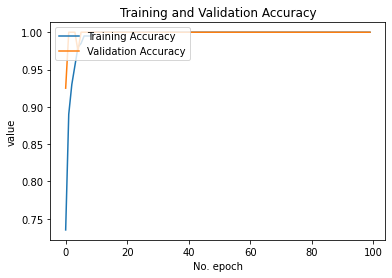

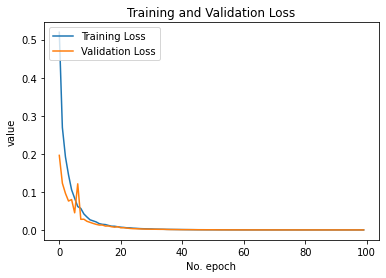

In [11]:
#visualisasi performa
plt.plot(model_baru1.history['accuracy'], label='Training Accuracy')
plt.plot(model_baru1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_baru1.history['loss'], label='Training Loss')
plt.plot(model_baru1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [16]:
model_baru.save('model_deteksi_tumor_trash.h5')

In [17]:
import requests
from io import BytesIO

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [19]:
input_size = (160, 160)
channel = (3, )
input_shape = input_size + channel

#define labels
labels = ['Normal', 'Tumor']

In [21]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

1/1 [==============================] - 0s 52ms/step
Normal 1.0


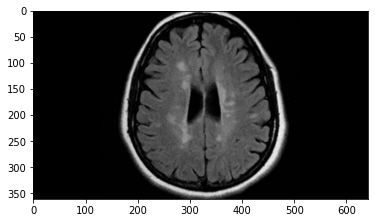

In [22]:
im = Image.open("/content/drive/My Drive/Dataset/MRI_BRAIN_TUMOR_DETECTION/Prediction/no 8.jpg")
X = preprocess(im,(160,160))
X = reshape([X])
y = model_baru.predict(X)
plt.imshow(im)
print( labels[np.argmax(y)], np.max(y) )

1/1 [==============================] - 0s 47ms/step
Tumor 0.9999945


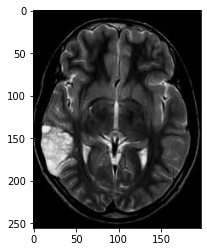

In [24]:
im = Image.open("/content/drive/My Drive/Dataset/MRI_BRAIN_TUMOR_DETECTION/Prediction/Y252.jpg")
X = preprocess(im,(160,160))
X = reshape([X])
y = model_baru.predict(X)
plt.imshow(im)
print( labels[np.argmax(y)], np.max(y) )